# Multiclass version of our mushroom classifier

In [1]:
MW_DATASET_VERSION = 'mushroom_world_2017_10_30'
MW_DATASET_URL = 'https://s3.eu-central-1.amazonaws.com/deep-shrooms/{}.zip'.format(MW_DATASET_VERSION)
MW_DATASET_PATH = 'data/{}/'.format(MW_DATASET_VERSION)

LP_DATASET_VERSION = 'luontoportti_2017_10_30'
LP_DATASET_URL = 'https://s3.eu-central-1.amazonaws.com/deep-shrooms/{}.zip'.format(LP_DATASET_VERSION)
LP_DATASET_PATH = 'data/{}/'.format(LP_DATASET_VERSION)

CLASSES = ['edible', 'edible when prepared', 'inedible', 'poisonous', 'deadly']
INPUT_SHAPE = (256, 256, 3)
BATCH_SIZE = 128
EPOCHS = 12

In [2]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

def import_data_set(url):
    with urlopen(url) as zip_response:
        file_size = int(zip_response.headers.get('content-length'))
        print("File {} is {} MB large".format(url, file_size/1000000))
        with ZipFile(BytesIO(zip_response.read())) as zfile:
            zfile.extractall('./data')


In [3]:
import_data_set(MW_DATASET_URL)
import_data_set(LP_DATASET_URL)

File https://s3.eu-central-1.amazonaws.com/deep-shrooms/mushroom_world_2017_10_30.zip is 7.200944 MB large
File https://s3.eu-central-1.amazonaws.com/deep-shrooms/luontoportti_2017_10_30.zip is 11.243985 MB large


In [3]:
import keras
import pandas as pd
import numpy as np

mw_mushroom_classes = pd.read_json(MW_DATASET_PATH + 'mushroom_classes.json', lines=True)
mw_mushroom_imgs = pd.read_json(MW_DATASET_PATH + 'mushroom_imgs.json', lines=True)
mw_mushroom_info = mw_mushroom_imgs.merge(mw_mushroom_classes, how = "right", on = "name_latin")

lp_mushroom_classes = pd.read_csv(LP_DATASET_PATH + 'lp_mushroom_classes.csv', sep='\t')
lp_mushroom_imgs = pd.read_csv(LP_DATASET_PATH + 'lp_mushroom_imgs.csv', sep='\t')

Using TensorFlow backend.


In [4]:
print(lp_mushroom_imgs.at[0, 'edibility'])

syötävyys: o** – keittämisen jälkeen hyvä ruokasieni


## Format labels

Following labels will be formatted into 5 different classes.

### From mushroom.world
* inedible                202
* edible                  149
* poisonous                77
* edible and good          50
* edible and excellent     27
* lethally poisonous       16
* edible when cooked       15

### From luontoportti.fi

* syötävyys: *** – erinomainen ruokasieni 149
* syötävyys: * – syötävä ruokasieni 134
* syötävyys: *** – erinomainen ruokasieni, eviran suosittelema 124
* syötävyys: ** – hyvä ruokasieni 101
* syötävyys: ** – hyvä ruokasieni, eviran suosittelema 72
* syötävyys: o* – keittämisen jälkeen syötävä ruokasieni 51
* syötävyys: x – käyttökelvoton 48
* syötävyys: ††† – tappavan myrkyllinen 39
* syötävyys: o** – keittämisen jälkeen hyvä ruokasieni, eviran suosittelema 36
* syötävyys: † – lievästi myrkyllinen 27
* syötävyys: †† – myrkyllinen 24
* syötävyys: x – käyttökelvoton ruokasienenä 21
* syötävyys: o** – keittämisen jälkeen hyvä ruokasieni 18
* syötävyys: *** – erinomainen ruokasieni, eviran suosittelema. (lajiepiteetti 12
* syötävyys: x – syötäväksi kelpaamaton 12
* syötävyys: o** – keittämisen jälkeen hyvä ruokasieni, ei kuitenkaan suositella syötäväksi useita kertoja viikossa 12
* syötävyys: †††o*** – tuoreena tappavan myrkyllinen, oikein esikäsiteltynä erinomainen ruokasieni, eviran suosittelema 9
* syötävyys: * –  syötävä ruokasieni 9
* syötävyys: o* – ryöppäämisen jälkeen syötävä ruokasieni 9
* syötävyys: ** – hyvä ruokasieni, eviran suosittelema (saa myydä vaaleaorakkaan seassa) 9
* syötävyys: *** –  erinomainen ruokasieni 6
* syötävyys: x – ei syötävä ruokasieni (paitsi maustekäytössä) 5
* syötävyys: ††† –  tappavan myrkyllinen 3

### End result

* edible
* edible when prepared
* inedible
* poisonous
* deadly

In [5]:
mw_edible = ['edible', 'edible and good', 'edible and excellent']
lp_edible = ['syötävyys: *']

mw_edible_when_prepared = ['edible when cooked']
lp_edible_when_prepared = ['syötävyys: o', 'syötävyys: †††o*']

mw_inedible = ['inedible']
lp_inedible = ['syötävyys: x']

mw_poisonous = ['poisonous']
lp_poisonous = ['syötävyys: † –', 'syötävyys: †† –']

mw_deadly = ['lethally poisonous']
lp_deadly = ['syötävyys: †††']

print("Target classes: {}".format(CLASSES))

Target classes: ['edible', 'edible when prepared', 'inedible', 'poisonous', 'deadly']


In [6]:
#df2 = mw_mushroom_info.copy(deep=True)
#df3 = lp_mushroom_imgs.copy(deep=True)
mw_mushroom_info.edibility.value_counts()
#df3.edibility.value_counts()

inedible                202
edible                  149
poisonous                77
edible and good          50
edible and excellent     27
lethally poisonous       16
edible when cooked       15
Name: edibility, dtype: int64

In [7]:
df2 = mw_mushroom_info

df2.edibility = df2.edibility.where(~df2.edibility.isin(mw_edible), 'edible')
df2.edibility = df2.edibility.where(~df2.edibility.isin(mw_edible_when_prepared), 'edible when prepared')
df2.edibility = df2.edibility.where(~df2.edibility.isin(mw_deadly), 'deadly')

mw_mushroom_info.edibility.value_counts()

edible                  226
inedible                202
poisonous                77
deadly                   16
edible when prepared     15
Name: edibility, dtype: int64

In [8]:
df3 = lp_mushroom_imgs

df3.edibility = df3.edibility.apply(lambda x: CLASSES[0] if len([s for s in lp_edible if s in x]) > 0 else x)
df3.edibility = df3.edibility.apply(lambda x: CLASSES[1] if len([s for s in lp_edible_when_prepared if s in x]) > 0 else x)
df3.edibility = df3.edibility.apply(lambda x: CLASSES[2] if len([s for s in lp_inedible if s in x]) > 0 else x)
df3.edibility = df3.edibility.apply(lambda x: CLASSES[3] if len([s for s in lp_poisonous if s in x]) > 0 else x)
df3.edibility = df3.edibility.apply(lambda x: CLASSES[4] if len([s for s in lp_deadly if s in x]) > 0 else x)

lp_mushroom_imgs.edibility.value_counts()

edible                  616
edible when prepared    135
inedible                 86
poisonous                51
deadly                   42
Name: edibility, dtype: int64

In [9]:
from scipy import misc

def load_mushroom_images(folder_path, img_df):
    img_dict = {}
    for row in img_df.itertuples():
        img_dict[row.Index] = misc.imread(folder_path + row.file_path)
    return img_dict
        
mw_img_dict = load_mushroom_images(MW_DATASET_PATH, mw_mushroom_info)
lp_img_dict = load_mushroom_images(LP_DATASET_PATH, lp_mushroom_imgs)

# Add dictionaries as new columns to the dataframes
mw_mushroom_info['img'] = pd.Series(mw_img_dict)
lp_mushroom_imgs['img'] = pd.Series(lp_img_dict)

In [20]:
# Combining the two dataframes together

all_mushroom_df = mw_mushroom_info.append(lp_mushroom_imgs, ignore_index=True)

# Will result in a dataframe that has multiple NaN columns also in cases where 
# the data is available from the another column eg. name_fin or name_eng

print(all_mushroom_df.loc[0])
print(all_mushroom_df.loc[0].img.shape)
print()
print(all_mushroom_df.loc[1455])
print(all_mushroom_df.loc[1455].img.shape)
print("\nTotal amount of mushroom pictures: {}".format(len(all_mushroom_df)))

edibility                                              inedible
file_path                   mushroom_img/tylopilus_felleus0.jpg
img           [[[255, 255, 255], [255, 255, 255], [255, 255,...
img_url       http://www.mushroom.world/data/fungi/Tylopilus...
img_urls      [http://www.mushroom.world/data/fungi/Tylopilu...
name_eng                                          Bitter Bolete
name_fin                                                    NaN
name_img                                 tylopilus_felleus0.jpg
name_latin                                    Tylopilus felleus
url_mw        http://www.mushroom.world/show?n=Tylopilus-fel...
Name: 0, dtype: object
(256, 256, 3)

edibility                                                edible
file_path                   lp_mushroom_img/suillus_luteus6.jpg
img           [[[255, 255, 255], [255, 255, 255], [255, 255,...
img_url       http://www.luontoportti.com/suomi/images/24589...
img_urls                                                    NaN
na

In [22]:
# Generate the actual training data with edibility as the label

X = np.stack(all_mushroom_df.img.values)
y = all_mushroom_df.edibility.values

print(X.shape)
print(y.shape)

(1466, 256, 256, 3)
(1466,)


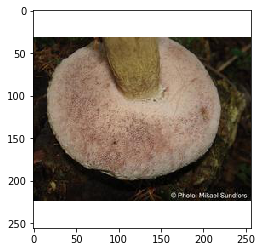

In [23]:
import matplotlib.pyplot as plt

# Last look at the pictures before dividing the RGB values by 255.

plt.imshow(X[3])
plt.show()

## Transforming RGB values into floats

CNNs want their input values as floats between 0 and 1? TODO

In [24]:
#X = X.reshape(len(X), 256, 256, 3, 1)

X = X.astype('float32')

X /=255

print(X[3].shape)
print(X[3][100][0:20])

(256, 256, 3)
[[ 0.07843138  0.07450981  0.05882353]
 [ 0.06666667  0.0627451   0.04705882]
 [ 0.05490196  0.05098039  0.03529412]
 [ 0.05882353  0.05490196  0.03921569]
 [ 0.07843138  0.06666667  0.04705882]
 [ 0.09019608  0.07843138  0.05882353]
 [ 0.08627451  0.07450981  0.05490196]
 [ 0.08235294  0.0627451   0.03921569]
 [ 0.08235294  0.0627451   0.03921569]
 [ 0.10588235  0.08627451  0.0627451 ]
 [ 0.11372549  0.08627451  0.05490196]
 [ 0.10980392  0.08235294  0.05098039]
 [ 0.16470589  0.13725491  0.10588235]
 [ 0.24705882  0.21960784  0.1882353 ]
 [ 0.26666668  0.23921569  0.20784314]
 [ 0.23529412  0.20784314  0.17647059]
 [ 0.45490196  0.41176471  0.34117648]
 [ 0.60000002  0.55686277  0.48627451]
 [ 0.57647061  0.53333336  0.4627451 ]
 [ 0.56862748  0.51764709  0.4509804 ]]


## One-hot encoding the edibility-labels

String values obviously have to be converted to numeric.

But they also have to be turned into a vector eg. [0 0 0 1 0]  
Because they way CNNs work they TODO

In [14]:
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()
y = encoder.fit_transform(y)

print(y.shape)
print(y[0])

(1466, 5)
[0 0 0 1 0]


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape)
print(y_train.shape)

(1172, 256, 256, 3)
(1172, 5)


In [16]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen = ImageDataGenerator()

In [17]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Activation, Dropout, Flatten

def new_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

def create_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

def old_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=X[0].shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1))
    model.add(Activation('sigmoid')) # sigmoid is the binary case of softmax 
    return model


In [18]:
model = new_model(INPUT_SHAPE, len(CLASSES))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

STEPS_PER_EPOCH = len(X_train) / 32
VALIDATION_STEPS = len(X_train) / 32

model.fit_generator(train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
          epochs=EPOCHS,
          steps_per_epoch=STEPS_PER_EPOCH, 
          validation_steps=VALIDATION_STEPS,
          verbose=1,
          validation_data=test_datagen.flow(X_test, y_test, batch_size=BATCH_SIZE))

score = model.evaluate(X_test, y_test, verbose=0)

Epoch 1/12
36/36 [============================>.] - ETA: 289s - loss: 6.9187 - acc: 0.5514

KeyboardInterrupt: 